In this notebook I create a Type 2 recommendation system which is based on user ratings and use SVD to build a system that recommends books.
The dataset is available at:
https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset/data

#  import library and data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
books = pd.read_csv('../input/bookcrossing-dataset/Book reviews/Book reviews/BX_Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")


In [ ]:
users = pd.read_csv('../input/bookcrossing-dataset/Book reviews/Book reviews/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")


In [ ]:
ratings = pd.read_csv('../input/bookcrossing-dataset/Book reviews/Book reviews/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")



# Applying EDA

# check missing value

In [ ]:
(books.isna().mean() * 100).sort_values(ascending=False)


Publisher              0.000737
Book-Author            0.000368
ISBN                   0.000000
Book-Title             0.000000
Year-Of-Publication    0.000000
Image-URL-S            0.000000
Image-URL-M            0.000000
Image-URL-L            0.000000
dtype: float64

In [ ]:
(users.isna().mean() * 100).sort_values(ascending=False)




User-ID     0.0
Location    0.0
Age         0.0
dtype: float64

In [ ]:
(ratings.isna().mean() * 100).sort_values(ascending=False)


User-ID        0.0
ISBN           0.0
Book-Rating    0.0
dtype: float64

In [ ]:
print(ratings.shape)
print(list(ratings.columns))

(1149780, 3)
['User-ID', 'ISBN', 'Book-Rating']


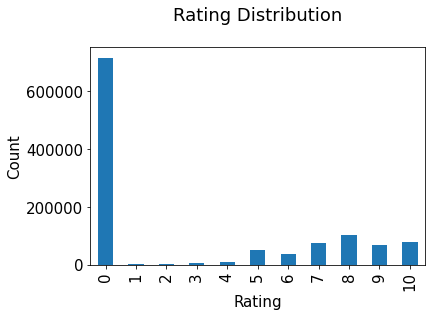

In [ ]:
plt.rc("font", size=15)
ratings.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
print(books.shape)
print(list(books.columns))

(271379, 8)
['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


In [ ]:
print(users.shape)
print(list(users.columns))

(278858, 3)
['User-ID', 'Location', 'Age']


In [ ]:
print(ratings.shape)
print(list(ratings.columns))

(1149780, 3)
['User-ID', 'ISBN', 'Book-Rating']


# handling with missing data  

In [ ]:
users['Age'] = pd.to_numeric(users['Age'], errors='coerce')
users['Age'] = users['Age'].clip(5, 90)
users['Age'].fillna(users['Age'].median(), inplace=True)


# Clean ratings   with deleting rate with 0 score  which means no opinion

In [ ]:
ratings = ratings[ratings['Book-Rating'] > 0]


#  Creat recommendation systeme type   Collaborative Filtering Using Matrix Facurization SVD  which help to recommend personalized book

# Prepare data for SVD

In [ ]:
from surprise import Dataset, Reader, SVD

reader = Reader(rating_scale=(1, 10))

data = Dataset.load_from_df(ratings[['User-ID', 'ISBN', 'Book-Rating']], reader)


# Train-test split & train SVD model

In [ ]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.2)

algo = SVD()

algo.fit(trainset)


# Predict ratings and recommend books  i choice to select the top 5 books

In [ ]:
def recommend_books(user_id, top_n=5):
    all_books = ratings['ISBN'].unique()
    rated_books = ratings[ratings['User-ID'] == user_id]['ISBN'].tolist()
    candidate_books = [b for b in all_books if b not in rated_books]

    predictions = [algo.predict(user_id, b) for b in candidate_books]
    predictions.sort(key=lambda x: x.est, reverse=True)
    top_predictions = predictions[:top_n]

    recommended = []
    for pred in top_predictions:
        book_info = books[books['ISBN'] == pred.iid]
        if not book_info.empty:  # Only add if book exists in books dataset
            info = book_info[['Book-Title','Book-Author']].iloc[0]
            recommended.append({
                'ISBN': pred.iid,
                'Title': info['Book-Title'],
                'Author': info['Book-Author'],
                'Predicted Rating': round(pred.est,2)
            })

    return pd.DataFrame(recommended)


In [ ]:
   recommend_books(276725, top_n=5)


,ISBN,Title,Author,Predicted Rating
0,0439425220,Harry Potter and the Chamber of Secrets Postca...,J. K. Rowling,9.11
1,0345339738,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,9.09
2,067168390X,Lonesome Dove,Larry McMurtry,9.03
3,0618002235,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,9.02
